   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.0 MB/s eta 0:00:00
✅ Optimization Status: Optimal

📊 Optimal Shipping Plan:
Send 50.0 units from W1 → C1
Send 50.0 units from W1 → C4
Send 60.0 units from W2 → C2
Send 20.0 units from W2 → C4
Send 40.0 units from W3 → C3
Send 80.0 units from W3 → C5

📦 Warehouse Inventory (Leftover):
W1: 0.0 units
W2: 0.0 units
W3: 0.0 units

⚠️ Customer Shortages (Unmet Demand):
C1: 0.0 units
C2: 0.0 units
C3: 0.0 units
C4: 0.0 units
C5: 0.0 units

💰 Total Minimized Cost =  540.0

📑 Final Allocation Table:
  Warehouse Customer  Quantity  Cost_per_unit
0        W1       C1      50.0              2
1        W1       C4      50.0              2
2        W2       C2      60.0              1
3        W2       C4      20.0              2
4        W3       C3      40.0              2
5        W3       C5      80.0              2

🏭 Warehouse Inventory:
  Warehouse  Inventory_Leftover
0        W1                 0.0
1        W2                 0.0
2 

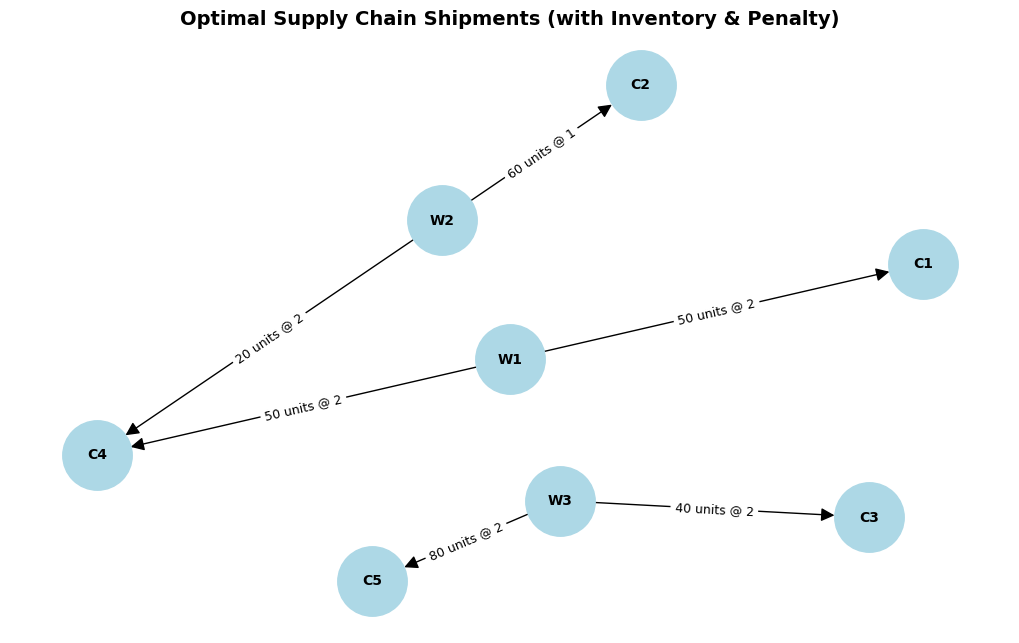

In [ ]:
# Author: Aarti Babasaheb Navale
# Description: Multi-warehouse, multi-customer supply chain cost minimization

!pip install pulp matplotlib pandas networkx

import pulp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# -------------------------------
# Step 1: Define the Sample Data
# -------------------------------

# Warehouses and supply capacity
warehouses = ['W1', 'W2', 'W3']
supply = {'W1': 100, 'W2': 80, 'W3': 120}

# Customers and demand requirements
customers = ['C1', 'C2', 'C3', 'C4', 'C5']
demand = {'C1': 50, 'C2': 60, 'C3': 40, 'C4': 70, 'C5': 80}

# Transportation cost matrix (warehouse → customer)
costs = {
    ('W1', 'C1'): 2, ('W1', 'C2'): 4, ('W1', 'C3'): 5, ('W1', 'C4'): 2, ('W1', 'C5'): 1,
    ('W2', 'C1'): 3, ('W2', 'C2'): 1, ('W2', 'C3'): 3, ('W2', 'C4'): 2, ('W2', 'C5'): 3,
    ('W3', 'C1'): 4, ('W3', 'C2'): 3, ('W3', 'C3'): 2, ('W3', 'C4'): 5, ('W3', 'C5'): 2,
}

# Additional costs
inventory_cost = 0.5   # per unit leftover stock
penalty_cost   = 10    # per unit unmet demand

# -------------------------------
# Step 2: Define the LP Problem
# -------------------------------
prob = pulp.LpProblem("SupplyChain_Optimization", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("ship", (warehouses, customers), lowBound=0, cat="Continuous")

# Extra decision variables
inventory = pulp.LpVariable.dicts("inventory", warehouses, lowBound=0, cat="Continuous")
shortage  = pulp.LpVariable.dicts("shortage", customers, lowBound=0, cat="Continuous")

# Objective function: Minimize (transport + inventory + penalty)
prob += (
    pulp.lpSum([costs[(i, j)] * x[i][j] for i in warehouses for j in customers])
    + pulp.lpSum([inventory_cost * inventory[i] for i in warehouses])
    + pulp.lpSum([penalty_cost * shortage[j] for j in customers])
)

# Constraints: Warehouse balance (supply used + leftover = total supply)
for i in warehouses:
    prob += pulp.lpSum([x[i][j] for j in customers]) + inventory[i] == supply[i], f"SupplyBalance_{i}"

# Constraints: Customer balance (received + shortage = demand)
for j in customers:
    prob += pulp.lpSum([x[i][j] for i in warehouses]) + shortage[j] == demand[j], f"DemandBalance_{j}"

# -------------------------------
# Step 3: Solve the Model
# -------------------------------
prob.solve(pulp.PULP_CBC_CMD(msg=0))

print(" Optimization Status:", pulp.LpStatus[prob.status])

print("\n Optimal Shipping Plan:")
for i in warehouses:
    for j in customers:
        if x[i][j].varValue > 0:
            print(f"Send {x[i][j].varValue:.1f} units from {i} → {j}")

print("\n Warehouse Inventory (Leftover):")
for i in warehouses:
    print(f"{i}: {inventory[i].varValue:.1f} units")

print("\n Customer Shortages (Unmet Demand):")
for j in customers:
    print(f"{j}: {shortage[j].varValue:.1f} units")

print("\n Total Minimized Cost = ", pulp.value(prob.objective))

# -------------------------------
# Step 4: Convert Results to DataFrame
# -------------------------------
# Shipment allocations
results = []
for i in warehouses:
    for j in customers:
        if x[i][j].varValue > 0:
            results.append([i, j, x[i][j].varValue, costs[(i,j)]])
df_ship = pd.DataFrame(results, columns=["Warehouse", "Customer", "Quantity", "Cost_per_unit"])

# Inventory table
df_inv = pd.DataFrame([(i, inventory[i].varValue) for i in warehouses], columns=["Warehouse", "Inventory_Leftover"])

# Shortage table
df_short = pd.DataFrame([(j, shortage[j].varValue) for j in customers], columns=["Customer", "Unmet_Demand"])

print("\n📑 Final Allocation Table:")
print(df_ship)
print("\n🏭 Warehouse Inventory:")
print(df_inv)
print("\n🛒 Customer Shortages:")
print(df_short)

# -------------------------------
# Step 5: Visualization
# -------------------------------
G = nx.DiGraph()

for row in df_ship.itertuples():
    G.add_edge(row.Warehouse, row.Customer, weight=row.Quantity, cost=row.Cost_per_unit)

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)

# Edge labels
edge_labels = {(u, v): f"{d['weight']:.0f} units @ {d['cost']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Optimal Supply Chain Shipments (with Inventory & Penalty)", fontsize=14, fontweight="bold")
plt.show()


In [ ]:
!git clone https://github.com/Aarteaa/Distribution-Center-Location-Optimization-.git


Cloning into 'Distribution-Center-Location-Optimization-'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 5.90 KiB | 5.90 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%cd Distribution-Center-Location-Optimization-


/content/Distribution-Center-Location-Optimization-
